In [318]:
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as sps
import statsmodels.api as sm
import statsmodels.stats as sms
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [203]:
data = pd.read_csv('../data/amsterdam_weekdays.csv')

data["person_capacity"] = data["person_capacity"].astype(int)
data["cleanliness_rating"] = data["cleanliness_rating"].astype(int)
data["host_is_superhost"] = data["host_is_superhost"].astype('category')
# data["realSum"] = data["realSum"].clip(0, 4000)

In [204]:
data.head()

,realSum,room_type,person_capacity,host_is_superhost,cleanliness_rating,bedrooms,dist,metro_dist
0,194.033698,Private room,2,False,10,1,5.022964,2.539380
1,344.245776,Private room,4,False,8,1,0.488389,0.239404
2,264.101422,Private room,2,False,9,1,5.748312,3.651621
3,433.529398,Private room,4,False,9,2,0.384862,0.439876
4,485.552926,Private room,2,True,10,1,0.544738,0.318693


## Анализ переменных

In [205]:
numerical_columns = [
    'realSum',
    'dist',
    'metro_dist'
]

categorical_columns = [
    'person_capacity',
    'cleanliness_rating',
    'bedrooms',
    'room_type',
    'host_is_superhost'
]

In [206]:
def describe_column(dataframe, column_name):
    data = dataframe[column_name]
    cnt, mean, std, *quartiles = data.describe()
    x_min, lower_quartile, x_median, upper_quartile, x_max = quartiles
    interquartile_range = upper_quartile - lower_quartile
    skewness = sps.skew(data)
    kurtosis = sps.kurtosis(data)
    return {
        "variable": column_name,
        "cnt": cnt,
        "mean": mean,
        "std": std,
        "x_min": x_min,
        "lower_quartile": lower_quartile,
        "upper_quartile": upper_quartile,
        "x_min": x_min,
        "x_max": x_max,
        "x_median": x_median,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "interquartile_range": interquartile_range,
    }

In [207]:
stat_dicts = []
for col in numerical_columns:
    stat_dicts.append(describe_column(data, col))

column_stats = pd.DataFrame(stat_dicts).set_index('variable').T

In [208]:
column_stats

variable,realSum,dist,metro_dist
cnt,1103.000000,1103.000000,1103.000000
mean,545.020526,2.841621,1.089439
std,416.974314,2.123245,0.836546
x_min,128.887118,0.015059,0.036530
lower_quartile,309.797764,1.302058,0.462983
upper_quartile,657.324303,3.648138,1.510629
x_max,7782.907225,11.187100,4.411915
x_median,430.248635,2.341366,0.856010
skewness,6.423628,1.454982,1.367371
kurtosis,87.636176,2.261120,1.796988


### Графики для количественных переменных

In [209]:
def plot_hist_density(dataframe, column_name, ax, stat='density'):
    data = dataframe[column_name].clip(-4000, 4000)
    sns.histplot(data, ax=ax, stat=stat)
    if stat == 'density':
        _, mu, sigma, *_ = data.describe()
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        density = sps.norm.pdf(x, mu, sigma)
        sns.lineplot(x=x, y=density, color='red', ax=ax, label=f'$Norm$({mu:.1f}, {sigma:.1f})')

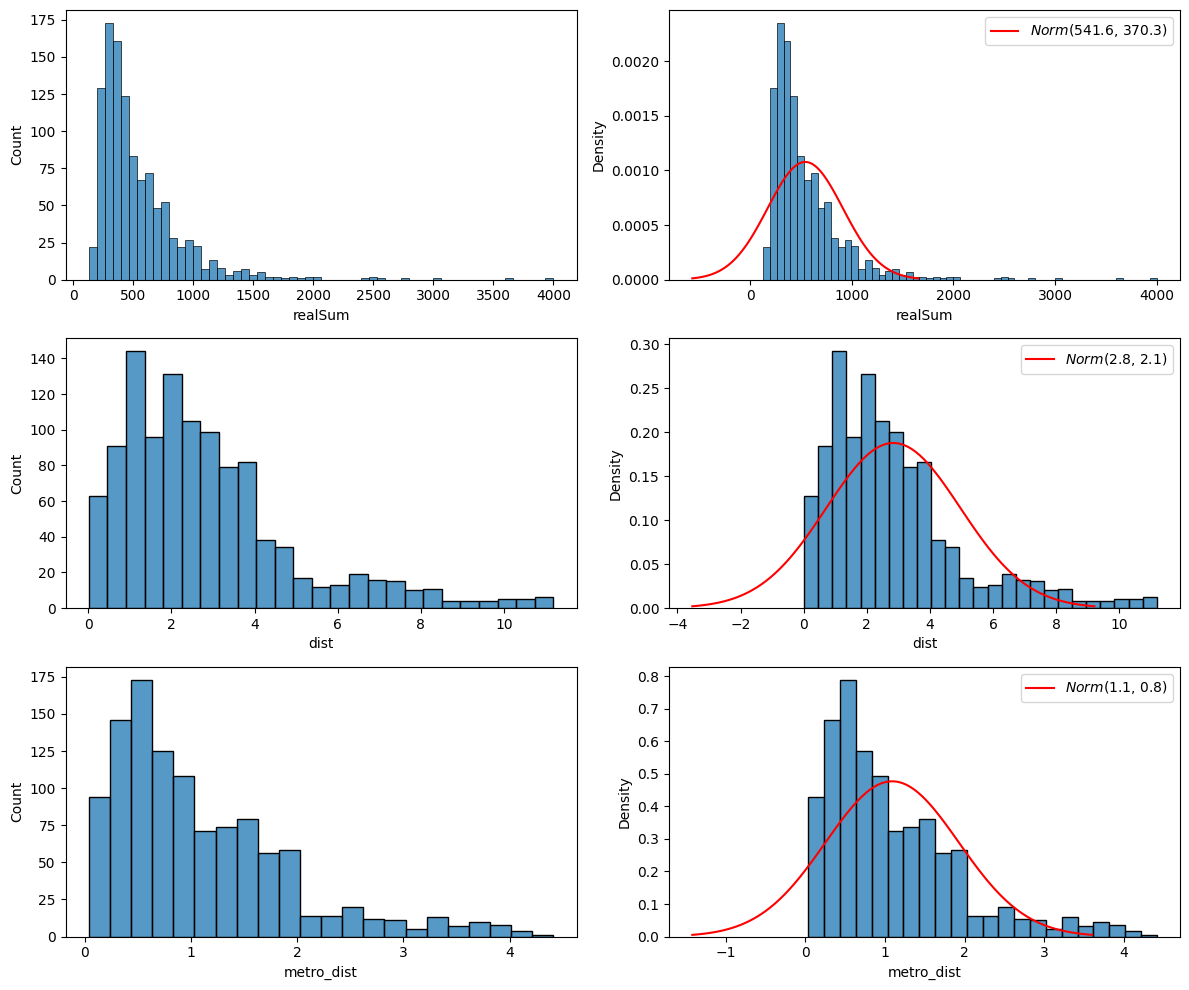

In [210]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(3):
    col = numerical_columns[i]
    plot_hist_density(data, col, ax[i%3][0], stat='count')
    plot_hist_density(data, col, ax[i%3][1], stat='density')

plt.tight_layout()
plt.show()

#### Выбросы

In [211]:
for col in numerical_columns:
    data[f'{col}_outlier'] = (data[col] - column_stats[col]['mean']).abs() > 3 * column_stats[col]['std']

In [212]:
print('Количество выбросов:')
print(data[[f'{col}_outlier' for col in numerical_columns]].sum())

Количество выбросов:
realSum_outlier       15
dist_outlier          23
metro_dist_outlier    23
dtype: int64


### Номинальные переменные

In [213]:
from IPython.display import display

In [214]:
cat_variable_stats = []

for col in categorical_columns:
    group_cnts = data[col].value_counts()
    group_freqs = group_cnts / group_cnts.sum()
    cat_variable_stats.append(pd.DataFrame({"cnt": group_cnts, "freqs": group_freqs}))

for var in cat_variable_stats:
    display(var.sort_index())

,cnt,freqs
person_capacity,,
2,656,0.594742
3,79,0.071623
4,333,0.301904
5,11,0.009973
6,24,0.021759


,cnt,freqs
cleanliness_rating,,
4,2,0.001813
5,1,0.000907
6,9,0.008160
7,11,0.009973
8,87,0.078876
9,334,0.302811
10,659,0.597461


,cnt,freqs
bedrooms,,
0,83,0.075249
1,719,0.651859
2,218,0.197643
3,74,0.067090
4,7,0.006346
5,2,0.001813


,cnt,freqs
room_type,,
Entire home/apt,538,0.487761
Private room,559,0.506800
Shared room,6,0.005440


,cnt,freqs
host_is_superhost,,
False,780,0.707162
True,323,0.292838


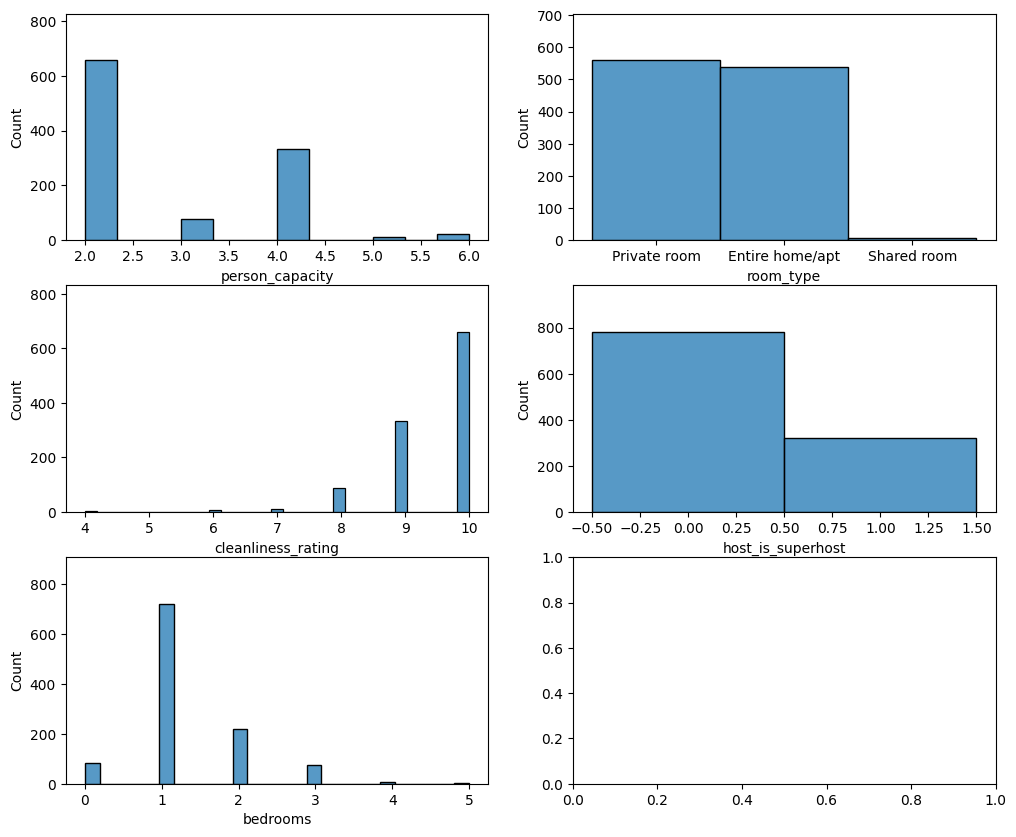

In [215]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(5):
    ax = axes[i%3][i//3]
    sns.histplot(data[categorical_columns[i]], ax=ax)
    l, h = ax.get_ylim()
    ax.set_ylim(l, h * 1.2)

plt.show()

#### Проведем укрупнение

In [216]:
data['cleanliness_rating_grouped'] = data['cleanliness_rating'].map({
    4: '8 or less',
    5: '8 or less',
    6: '8 or less',
    7: '8 or less',
    8: '8 or less',
    9: '9',
    10: '10',
}).astype('category')

In [217]:
data['bedrooms_grouped'] = data['bedrooms'].map({
    0: '0',
    1: '1',
    2: '2',
    3: '3+',
    4: '3+',
    5: '3+',
}).astype('category')

In [218]:
data['person_capacity_grouped'] = data['person_capacity'].map({
    2: '2',
    3: '3',
    4: '4+',
    5: '4+',
    6: '4+',
}).astype('category')

In [219]:
data['room_type_grouped'] = data['room_type'].map({
    'Private room': 'room',
    'Shared room': 'room',
    'Entire home/apt': 'entire home/apt',
}).astype('category')

In [220]:
grouped_categorical_columns = [
    'person_capacity_grouped',
    'cleanliness_rating_grouped',
    'bedrooms_grouped',
    'room_type_grouped',
    'host_is_superhost'
]

In [221]:
grouped_cat_variable_stats = []

for col in grouped_categorical_columns:
    group_cnts = data[col].value_counts()
    group_freqs = group_cnts / group_cnts.sum()
    grouped_cat_variable_stats.append(pd.DataFrame({"cnt": group_cnts, "freqs": group_freqs}))

for var in grouped_cat_variable_stats:
    display(var.sort_index())

,cnt,freqs
person_capacity_grouped,,
2,656,0.594742
3,79,0.071623
4+,368,0.333636


,cnt,freqs
cleanliness_rating_grouped,,
10,659,0.597461
8 or less,110,0.099728
9,334,0.302811


,cnt,freqs
bedrooms_grouped,,
0,83,0.075249
1,719,0.651859
2,218,0.197643
3+,83,0.075249


,cnt,freqs
room_type_grouped,,
entire home/apt,538,0.487761
room,565,0.512239


,cnt,freqs
host_is_superhost,,
False,780,0.707162
True,323,0.292838


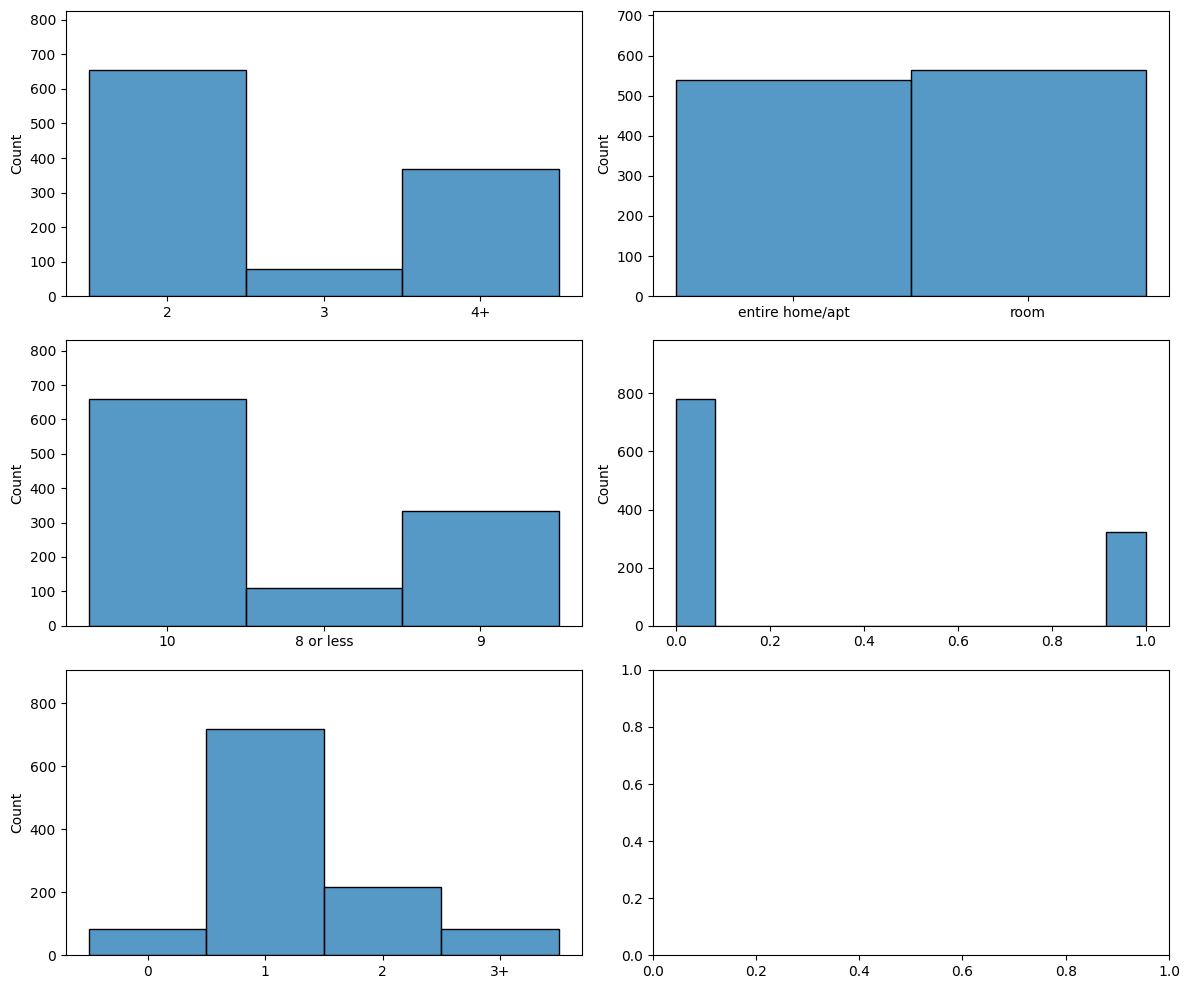

In [222]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

for i in range(5):
    ax = axes[i%3][i//3]
    sns.histplot(sorted(data[grouped_categorical_columns[i]]), ax=ax)
    l, h = ax.get_ylim()
    ax.set_ylim(l, h * 1.2)

plt.tight_layout()
plt.show()

## Анализ статистической связи

### Относительные переменные

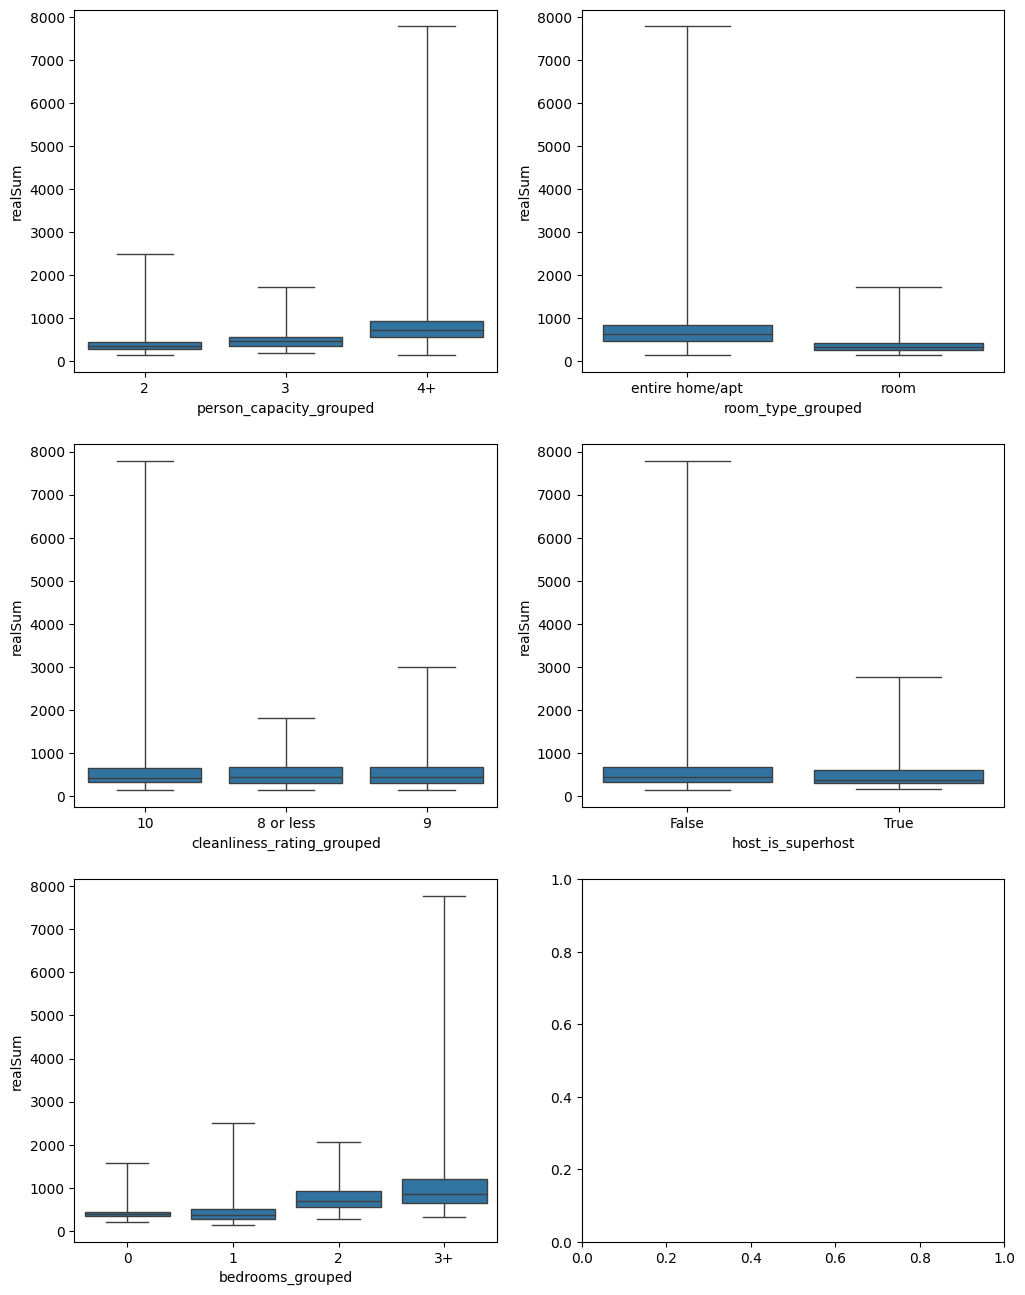

In [223]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(12, 16))

for i in range(5):
    ax = axes[i%3][i//3]
    col = grouped_categorical_columns[i]
    sns.boxplot(data=data, x=col, y="realSum", ax=ax, whis=(0, 100))

plt.show()

In [224]:
for i in range(5):
    col = grouped_categorical_columns[i]
    subsets = []
    for val in data[col].unique():
        subsets.append(data["realSum"][data[col] == val])
    print(f'Kruskal test for {col}')
    test_res = sps.kruskal(*subsets)
    print(f'p-value = {test_res.pvalue:.5f}')
    print(f'Null hypothesis is rejected: {test_res.pvalue < 0.05}')
    print()

Kruskal test for person_capacity_grouped
p-value = 0.00000
Null hypothesis is rejected: True

Kruskal test for cleanliness_rating_grouped
p-value = 0.88646
Null hypothesis is rejected: False

Kruskal test for bedrooms_grouped
p-value = 0.00000
Null hypothesis is rejected: True

Kruskal test for room_type_grouped
p-value = 0.00000
Null hypothesis is rejected: True

Kruskal test for host_is_superhost
p-value = 0.00051
Null hypothesis is rejected: True



### Порядковые и номинальные переменные

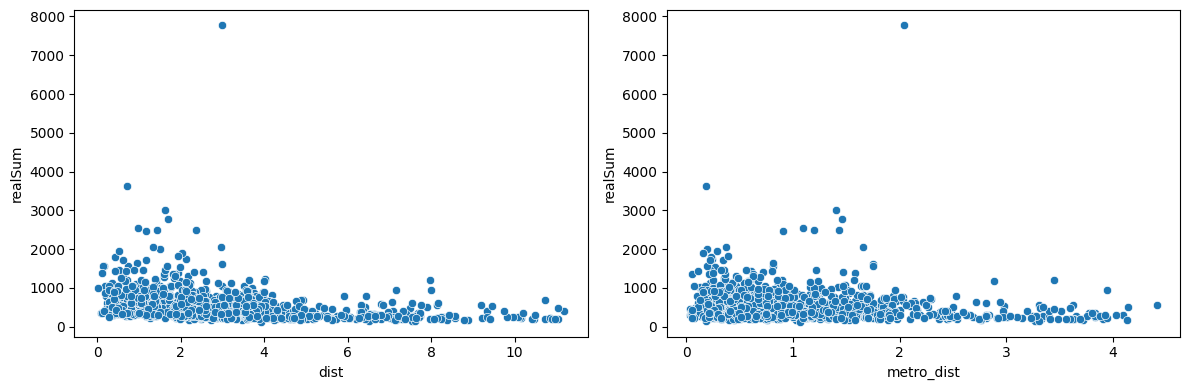

In [225]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

for i in range(2):
    ax = axes[i]
    col = numerical_columns[1:][i]
    sns.scatterplot(data=data, x=col, y="realSum", ax=ax)

plt.tight_layout()
plt.show()

In [226]:
corr_dicts = []
tests = [sps.kendalltau, sps.pearsonr, sps.spearmanr]

for col in numerical_columns[1:]:
    a, b = data[col], data["realSum"]
    for test in tests:
        corr = test(a, b)
        corr_dicts.append({
            'variable': col,
            'test': test.__name__,
            'test statistic': corr.statistic,
            'test p-value': corr.pvalue,
            'null hypothesis rejected': corr.pvalue < 0.05,
        })

In [227]:
pd.DataFrame(corr_dicts).set_index(['variable', 'test'])

test statistic  test p-value  null hypothesis rejected
variable   test                                                              
dist       kendalltau       -0.264824  1.617648e-39                      True
           pearsonr         -0.258692  2.528289e-18                      True
           spearmanr        -0.389795  2.436400e-41                      True
metro_dist kendalltau       -0.131207  7.170382e-11                      True
           pearsonr         -0.142298  2.087936e-06                      True
           spearmanr        -0.192857  1.057368e-10                      True

### Анализ таблиц - связи между независимыми переменными

#### Независимая номинальная - независимая номинальная

In [330]:
def cramer_v(confusion_matrix):
    n_observations = confusion_matrix.sum()
    min_shape = min(*confusion_matrix.shape)
    v_cramer_stat = np.sqrt(chi2_stat / (min_shape * n_observations))
    return v_cramer_stat

In [336]:
for left, right in itertools.combinations(grouped_categorical_columns, 2):
    confusion_matrix = pd.crosstab(data[left], data[right]).to_numpy()
    res = sps.chi2_contingency(confusion_matrix)
    chi2_stat, pval = res.statistic, res.pvalue
    v_cramer_stat = cramer_v(confusion_matrix)
    print(f'{left} to {right}:')
    print(f'Chi Squared statistic = {chi2_stat:.4f}')
    print(f'Chi Squared test p_value = {pval:.4f}')
    print(f'Cramer\'s V = {v_cramer_stat:.4f}')
    display(pd.crosstab(data[left], data[right]))
    print('=' * 60)

person_capacity_grouped to cleanliness_rating_grouped:
Chi Squared statistic = 14.0116
Chi Squared test p_value = 0.0073
Cramer's V = 0.0651


cleanliness_rating_grouped,10,8 or less,9
person_capacity_grouped,,,
2,420,57,179
3,47,9,23
4+,192,44,132


person_capacity_grouped to bedrooms_grouped:
Chi Squared statistic = 601.8884
Chi Squared test p_value = 0.0000
Cramer's V = 0.4265


bedrooms_grouped,0,1,2,3+
person_capacity_grouped,,,,
2,66,580,10,0
3,9,45,21,4
4+,8,94,187,79


person_capacity_grouped to room_type_grouped:
Chi Squared statistic = 149.9516
Chi Squared test p_value = 0.0000
Cramer's V = 0.2607


room_type_grouped,entire home/apt,room
person_capacity_grouped,,
2,223,433
3,44,35
4+,271,97


person_capacity_grouped to host_is_superhost:
Chi Squared statistic = 11.2659
Chi Squared test p_value = 0.0036
Cramer's V = 0.0715


host_is_superhost,False,True
person_capacity_grouped,,
2,439,217
3,60,19
4+,281,87


cleanliness_rating_grouped to bedrooms_grouped:
Chi Squared statistic = 12.4457
Chi Squared test p_value = 0.0527
Cramer's V = 0.0613


bedrooms_grouped,0,1,2,3+
cleanliness_rating_grouped,,,,
10,39,454,120,46
8 or less,9,67,24,10
9,35,198,74,27


cleanliness_rating_grouped to room_type_grouped:
Chi Squared statistic = 1.6707
Chi Squared test p_value = 0.4337
Cramer's V = 0.0275


room_type_grouped,entire home/apt,room
cleanliness_rating_grouped,,
10,311,348
8 or less,57,53
9,170,164


cleanliness_rating_grouped to host_is_superhost:
Chi Squared statistic = 135.4589
Chi Squared test p_value = 0.0000
Cramer's V = 0.2478


host_is_superhost,False,True
cleanliness_rating_grouped,,
10,381,278
8 or less,107,3
9,292,42


bedrooms_grouped to room_type_grouped:
Chi Squared statistic = 215.4484
Chi Squared test p_value = 0.0000
Cramer's V = 0.3125


room_type_grouped,entire home/apt,room
bedrooms_grouped,,
0,29,54
1,255,464
2,175,43
3+,79,4


bedrooms_grouped to host_is_superhost:
Chi Squared statistic = 14.3349
Chi Squared test p_value = 0.0025
Cramer's V = 0.0806


host_is_superhost,False,True
bedrooms_grouped,,
0,66,17
1,484,235
2,161,57
3+,69,14


room_type_grouped to host_is_superhost:
Chi Squared statistic = 32.4697
Chi Squared test p_value = 0.0000
Cramer's V = 0.1213


host_is_superhost,False,True
room_type_grouped,,
entire home/apt,424,114
room,356,209


#### Независимая номинальная - независимая количественная

In [348]:
cat2num_dicts = []
for col in grouped_categorical_columns:
    for num_col in numerical_columns[1:]:
        subsets = []
        for val in data[col].unique():
            subsets.append(data[num_col][data[col] == val])
        test_res = sps.kruskal(*subsets)
        cat2num_dicts.append({
            'numerical': num_col,
            'categorical': col,
            'p-value': test_res.pvalue,
            'rejected': test_res.pvalue < 0.05,
            'statistic': test_res.statistic,
        })

pd.DataFrame(cat2num_dicts).set_index(['categorical', 'numerical'])

p-value  rejected  statistic
categorical                numerical                                
person_capacity_grouped    dist        0.209827     False   3.122948
                           metro_dist  0.265172     False   2.654752
cleanliness_rating_grouped dist        0.545021     False   1.213863
                           metro_dist  0.516005     False   1.323277
bedrooms_grouped           dist        0.001971      True  14.826694
                           metro_dist  0.078723     False   6.795116
room_type_grouped          dist        0.231085     False   1.434169
                           metro_dist  0.779579     False   0.078326
host_is_superhost          dist        0.551784     False   0.354131
                           metro_dist  0.268882     False   1.222441

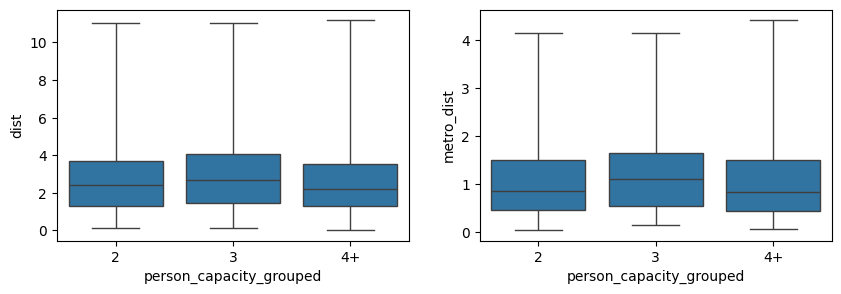

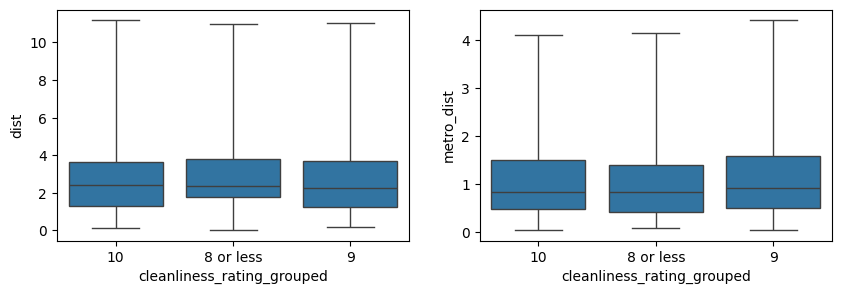

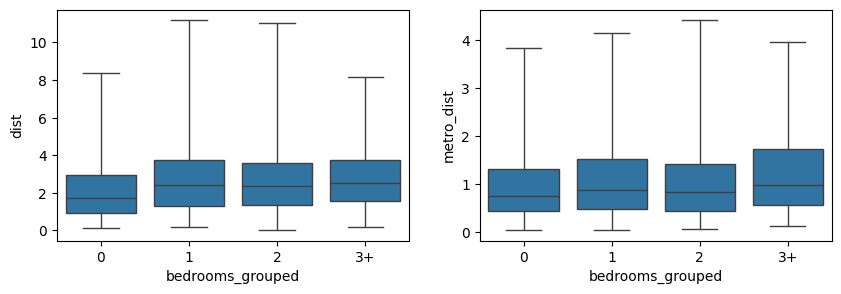

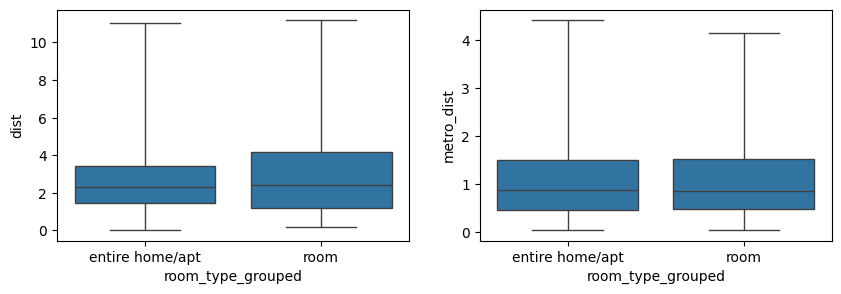

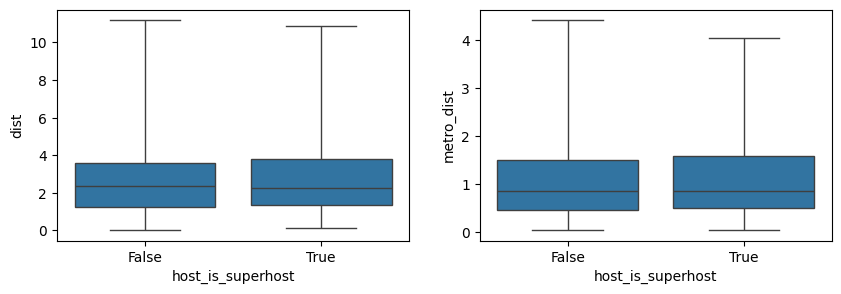

In [352]:
for cat_col in grouped_categorical_columns:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
    sns.boxplot(data=data, x=cat_col, y='dist', ax=axes[0], whis=(0, 100))
    sns.boxplot(data=data, x=cat_col, y='metro_dist', ax=axes[1], whis=(0, 100))
    plt.show()

#### Независимая количественная - Независимая количественная

In [353]:
corr_dicts = []
tests = [sps.kendalltau, sps.pearsonr, sps.spearmanr]

a, b = data['metro_dist'], data['dist']
for test in tests:
    corr = test(a, b)
    corr_dicts.append({
        'test': test.__name__,
        'test statistic': corr.statistic,
        'test p-value': corr.pvalue,
        'null hypothesis rejected': corr.pvalue < 0.05,
    })

pd.DataFrame(corr_dicts).set_index(['test'])

,test statistic,test p-value,null hypothesis rejected
test,,,
kendalltau,0.290350,2.836351e-47,True
pearsonr,0.412042,1.907484e-46,True
spearmanr,0.401195,6.585973e-44,True


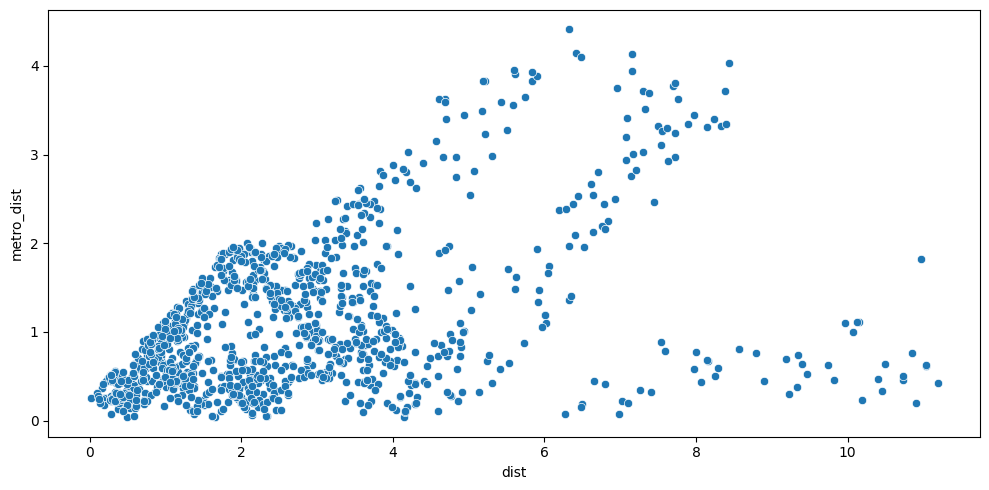

In [358]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data, x='dist', y='metro_dist')
plt.tight_layout()
plt.show()

## Моделирование

In [262]:
train, test = train_test_split(data, train_size=0.8)

In [270]:
Y = train['realSum']

numerical_values = train[numerical_columns[1:]]
dummies = pd.get_dummies(train[grouped_categorical_columns])

X = pd.concat([dummies, numerical_values], axis=1)
X = sm.add_constant(X)

In [271]:
Y_test = test['realSum']

test_numerical_values = test[numerical_columns[1:]]
test_dummies = pd.get_dummies(test[grouped_categorical_columns])

X_test = pd.concat([test_dummies, test_numerical_values], axis=1)
X_test = sm.add_constant(X_test)

In [274]:
model = sm.OLS(Y.astype(np.float64), X.astype(np.float64))

In [273]:
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realSum   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     77.30
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          9.97e-121
Time:                        15:08:40   Log-Likelihood:                -6141.2
No. Observations:                 882   AIC:                         1.231e+04
Df Residuals:                     870   BIC:                         1.236e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  257.3114      7.922     32.481      0.000     241.763     272.860
person_capacity_grouped_2                0.3391     16.888      0.020      0.984     -32.808      33.486
person_capacity_grouped_3               60.4253     23.689      2.551      0.011      13.931     106.920
person_capacity_grouped_4+             196.5469     18.093     10.863      0.000     161.036     232.058
cleanliness_rating_grouped_10          106.1381     12.999      8.165      0.000      80.625     131.652
cleanliness_rating_grouped_8 or less    60.2010     20.534      2.932      0.003      19.899     100.503
cleanliness_rating_grouped_9            90.9722     14.433      6.303      0.000      62.645     119.299
bedrooms_grouped_0                     -92.3285     28.524     -3.237      0.001    -148.312     -36.345
bedrooms_grouped_1                     -32.3385     18.017     -1.795      0.073     -67.699       3.023
bedrooms_grouped_2                      64.2611     21.510      2.988      0.003      22.044     106.479
bedrooms_grouped_3+                    317.7172     29.381     10.814      0.000     260.051     375.383
room_type_grouped_entire home/apt      228.5458     10.191     22.425      0.000     208.543     248.548
room_type_grouped_room                  28.7656     11.088      2.594      0.010       7.003      50.529
host_is_superhost_False                121.9546      9.881     12.342      0.000     102.560     141.349
host_is_superhost_True                 135.3567     12.032     11.250      0.000     111.742     158.972
dist                                   -39.6162      4.646     -8.527      0.000     -48.735     -30.498
metro_dist                             -31.4106     11.499     -2.732      0.006     -53.979      -8.843
==============================================================================
Omnibus:                      700.974   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19931.105
Skew:                           3.388   Prob(JB):                         0.00
Kurtosis:                      25.281   Cond. No.                     9.90e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.46e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [282]:
vif = pd.DataFrame()
X_q = X.select_dtypes(include='float64')
vif["variable"] = X_q.columns
vif["VIF"] = [sms.outliers_influence.variance_inflation_factor(X_q.values, i) for i in range(X_q.shape[1])]

In [278]:
vif

,variable,VIF
0,const,3.441038
1,dist,1.237780
2,metro_dist,1.237780


In [284]:
het_white_result = pd.DataFrame(sms.diagnostic.het_white(fitted_model.resid, X), index = ['LM', 'LM_P', 'F', 'F_P'])
het_white_result

,0
LM,123.150427
LM_P,0.000006
F,2.143742
F_P,0.000002


## To be done